## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [1]:
import matplotlib
matplotlib.use("Agg")
import matplotlib.pylab as plt
import IPython.display as ipd

import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence

%matplotlib inline

In [2]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

#### Setup hparams

In [3]:
hparams = create_hparams("distributed_run=0,mask_padding=0")
hparams.sampling_rate = 22050
hparams.filter_length = 1024
hparams.hop_length = 256
hparams.win_length = 1024

/Users/hendorf/anaconda/envs/audiodrama/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.22) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)


INFO:tensorflow:Parsing command line hparams: distributed_run=0,mask_padding=0


#### Load model from checkpoint

In [4]:
checkpoint_path = "/Users/hendorf/code/audiodrama/project/tacotron2/outdir/checkpoint_278500"

#checkpoint_path ="/Users/hendorf/code/audiodrama/project/tacotron2/outdir-de/checkpoint_24500"


model = load_model(hparams)
try:
    model = model.module
except:
    pass
model.load_state_dict({k.replace('module.',''):v for k,v in torch.load(checkpoint_path)['state_dict'].items()})
_ = model.eval()

/Users/hendorf/code/audiodrama/project/tacotron2/layers.py:35: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  self.conv.weight, gain=torch.nn.init.calculate_gain(w_init_gain))
/Users/hendorf/code/audiodrama/project/tacotron2/layers.py:15: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  gain=torch.nn.init.calculate_gain(w_init_gain))


#### Prepare text input

In [21]:
text = "Once upon a time there was a little mermaid named Siren, who lived with her step mother under the sea, She didn't get to go out of the Sea like any other."
#text = "Once upon a time . . . in a splendid palace on the bed of the bluest ocean, lived the Sea King, a wise old triton with a long flowing white beard. He lived in a magnificent palace, built of gaily coloured coral and seashells, together with his five daughters, very beautiful mermaids. Sirenetta, the youngest and loveliest of them all, also had a beautiful voice, and when she sang, the fishes flocked from all over the sea to listen to her. The shells gaped wide, showing their pearls and even the jellyfish stopped to listen. The young mermaid often sang, and each time, she would gaze upwards, seeking the faint sunlight that scarcely managed to filter down into the depths."
#text = "Willkomen bei dem BBQ, es gibt hier Bratwürste und Käseschnitzel in der Lounge. Melden Sie sich hier an."
#text = "Welcome to the Big Data Barbeque, we are happy we have some great speakers from all over Europe here."
#text = "Once upon a time in a splendid palace on the bed of the bluest ocean, lived the Sea King, a wise old triton with a long flowing white beard. "
#text = "He lived in a magnificent palace, built of gaily coloured coral and seashells, together with his five daughters, very beautiful mermaids. Sirenetta, the youngest and loveliest of them all, also had a beautiful voice, and when she sang, the fishes flocked from all over the sea to listen to her. The shells gaped wide, showing their pearls and even the jellyfish stopped to listen. The young mermaid often sang, and each time, she would gaze upwards, seeking the faint sunlight that scarcely managed to filter down into the depths. Oh, how I'd love to go up there and at last see the sky, which everyone says is so pretty, and hear the voices of humans and smell the scent of the flowers! 'You're still too young!' said her mother. 'In a year or two, when you\'re fifteen. Only then will the King let you go up there, like your sisters!' Sirenetta spent her time wishing for the world of humans, she listened to her sisters' stories, and every time they returned frorm the surface, she would ask them questions, to satisfy her curiosity."
#text = "ba da blak kli hrrksch kaka me lollm hhgat!"
#text="Muss ich drei Stunden lang alte Familienfotos mit dir gucken mit einem Schwerpunkt auf süßen Enkeln in Badewannen?"
#text="Have a good flight! Enjoy and greeting to your mother!"

#text = "Hallo Willkomen bei meinem ersten Satz, ist er gut?"

sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

#### Decode text input and plot results

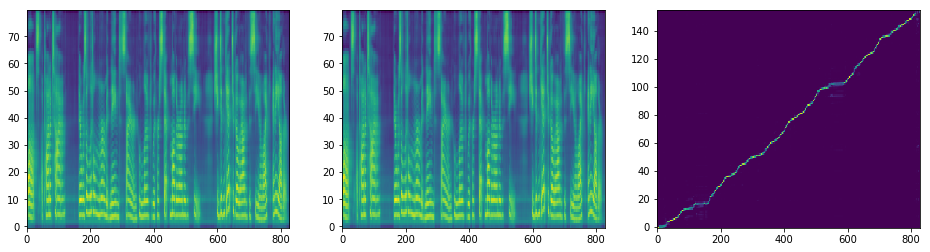

In [22]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.data.cpu().numpy()[0],
           mel_outputs_postnet.data.cpu().numpy()[0],
           alignments.data.cpu().numpy()[0].T))

#### Load TacotronSTFT and convert mel-spectrogram to spectrogram

In [23]:
taco_stft = TacotronSTFT(
    hparams.filter_length, hparams.hop_length, hparams.win_length, 
    sampling_rate=hparams.sampling_rate)
mel_decompress = taco_stft.spectral_de_normalize(mel_outputs_postnet)
mel_decompress = mel_decompress.transpose(1, 2).data.cpu()
spec_from_mel_scaling = 1000
spec_from_mel = torch.mm(mel_decompress[0], taco_stft.mel_basis)
spec_from_mel = spec_from_mel.transpose(0, 1).unsqueeze(0)
spec_from_mel = spec_from_mel * spec_from_mel_scaling

#### Synthesize audio from spectrogram using the Griffin-Lim algorithm

In [24]:
waveform = griffin_lim(torch.autograd.Variable(spec_from_mel[:, :, :-1]), 
                       taco_stft.stft_fn, 60)

In [25]:
ipd.Audio(waveform[0].data.cpu().numpy(), rate=hparams.sampling_rate) 

In [20]:
text

'Once upon a time . . . in a splendid palace on the bed of the bluest ocean, lived the Sea King, a wise old triton with a long flowing white beard. He lived in a magnificent palace, built of gaily coloured coral and seashells, together with his five daughters, very beautiful mermaids. Sirenetta, the youngest and loveliest of them all, also had a beautiful voice, and when she sang, the fishes flocked from all over the sea to listen to her. The shells gaped wide, showing their pearls and even the jellyfish stopped to listen. The young mermaid often sang, and each time, she would gaze upwards, seeking the faint sunlight that scarcely managed to filter down into the depths.'

In [11]:
import librosa

In [12]:
librosa.output.write_wav(
    '/Users/hendorf/Downloads/onceuponatime_278500.wav', 
    waveform[0].data.cpu().numpy(), 
    hparams.sampling_rate)

In [13]:
torch.cuda.empty_cache()

In [14]:
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='GeForce GTX 1080', major=6, minor=1, total_memory=8191MB, multi_processor_count=20)